# Bank Earnings: Regulatory Topic & Sentiment Analysis

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("transcript_sentences.csv")
df['quarter_year'] = df['quarter'] + " " + df['year'].astype(str)


## 1. What are the most common topics (financial and regulatory)?

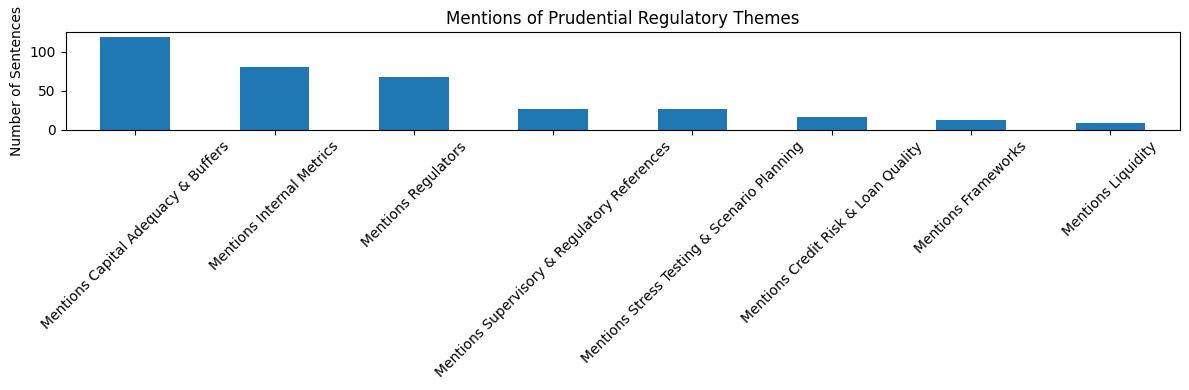

In [2]:

reg_topics = [col for col in df.columns if col.startswith("Mentions ")]
reg_summary = df[reg_topics].apply(lambda col: (col == "Yes").sum()).sort_values(ascending=False)
reg_summary.plot(kind='bar', figsize=(12,4), title='Mentions of Prudential Regulatory Themes')
plt.ylabel("Number of Sentences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. What do executives say when they mention Prudential Regulation Themes?

In [3]:

mentions_mask = df[[col for col in df.columns if col.startswith("Mentions ")]].eq("Yes").any(axis=1)
reg_df = df[mentions_mask].copy()
print(f"Total rows where regulation themes are mentioned: {len(reg_df)}")
reg_df[['quarter', 'year', 'speaker', 'sentence'] + [c for c in df.columns if c.startswith("Mentions ")][:3]].head(10)


Total rows where regulation themes are mentioned: 287


,quarter,year,speaker,sentence,Mentions Capital Adequacy & Buffers,Mentions Liquidity,Mentions Credit Risk & Loan Quality
41,Q1,2022,Jane Fraser,"At the same time, a sharp increase in interest...",Yes,No,No
103,Q1,2022,Mark Mason,"Sequentially, net interest margin increased by...",No,No,No
108,Q1,2022,Mark Mason,"From a capital perspective, we ended the quart...",Yes,No,No
111,Q1,2022,Mark Mason,"However, it is important to note that despite ...",Yes,No,No
112,Q1,2022,Mark Mason,We expect the combination of net income genera...,Yes,No,No
116,Q1,2022,Mark Mason,Given the sizeable impact of some of the drive...,Yes,No,No
120,Q1,2022,Mark Mason,"Fourth, the increase in disallowed DTA largely...",Yes,No,No
122,Q1,2022,Mark Mason,"With all of that said, as I just mentioned, we...",Yes,No,No
204,Q1,2022,Erika Najarian,"I just wanted to ask you a question, Jane and ...",Yes,No,No
205,Q1,2022,Erika Najarian,"So from the 11.4%, you said that net income ca...",Yes,No,No


## 3. What is the sentiment trend around regulatory themes by quarter?

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


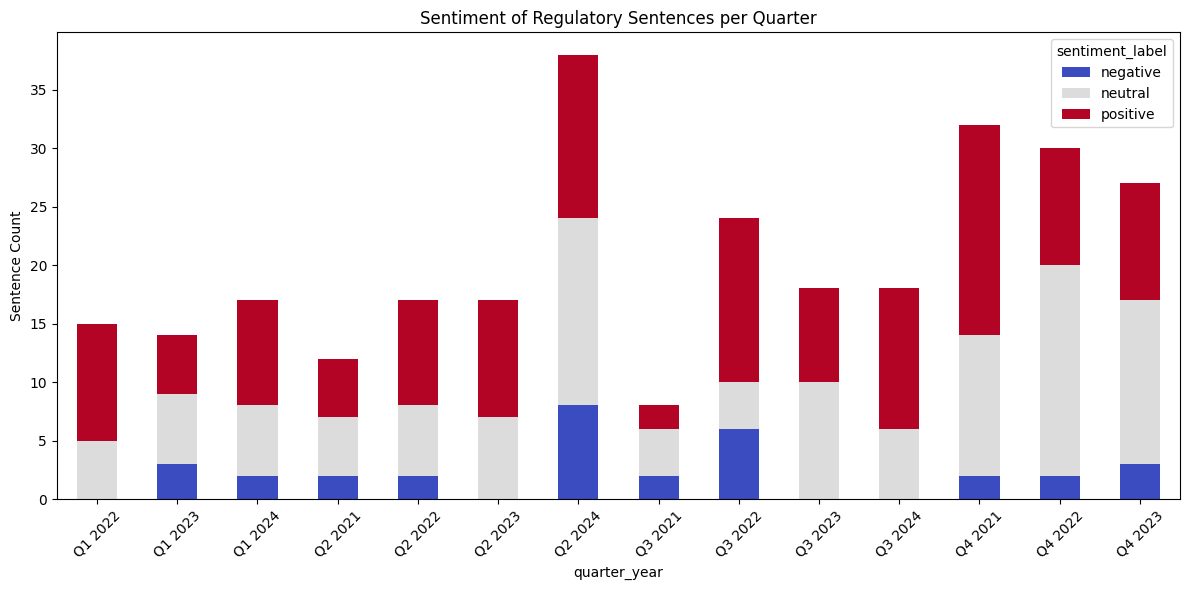

In [4]:

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

reg_df['sentiment_score'] = reg_df['sentence'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
reg_df['sentiment_label'] = reg_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')

sentiment_summary = reg_df.groupby(['quarter_year', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_summary.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm', title='Sentiment of Regulatory Sentences per Quarter')
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Are executives complaining, complying or preparing? (Manual hints based on keywords)

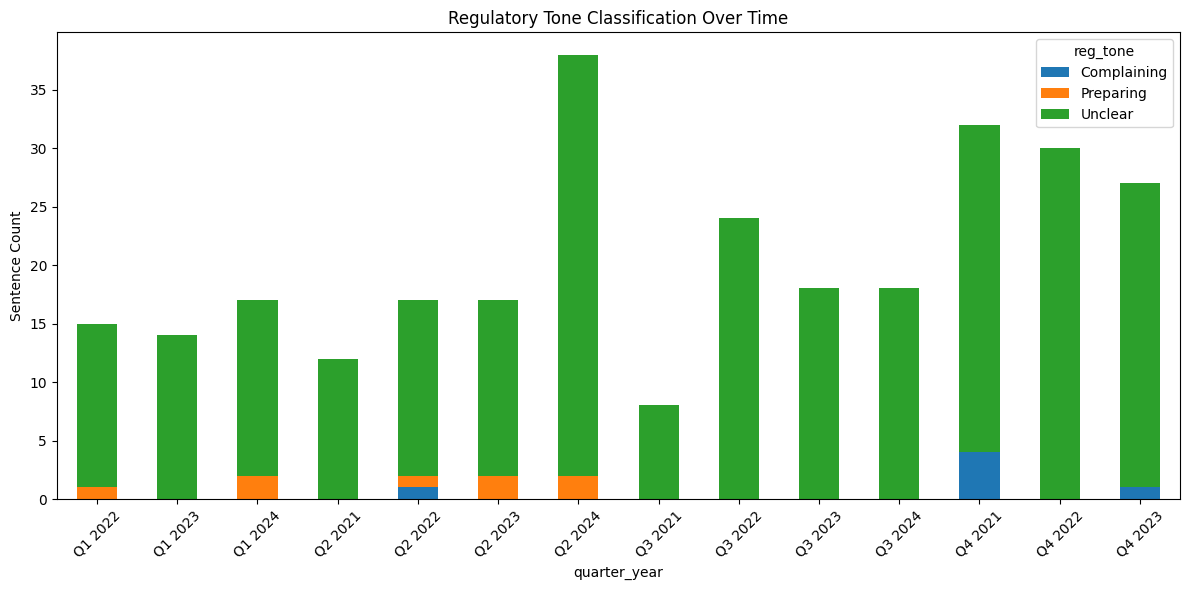

In [5]:

def classify_tone(text):
    text = text.lower()
    if any(word in text for word in ['concern', 'challenge', 'problem', 'headwind']):
        return 'Complaining'
    elif any(word in text for word in ['comply', 'compliance', 'met requirement', 'within range']):
        return 'Complying'
    elif any(word in text for word in ['prepare', 'planning', 'readiness', 'scenario']):
        return 'Preparing'
    return 'Unclear'

reg_df['reg_tone'] = reg_df['sentence'].apply(classify_tone)
tone_summary = reg_df.groupby(['quarter_year', 'reg_tone']).size().unstack(fill_value=0)
tone_summary.plot(kind='bar', stacked=True, figsize=(12,6), title='Regulatory Tone Classification Over Time')
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 1200x600 with 0 Axes>

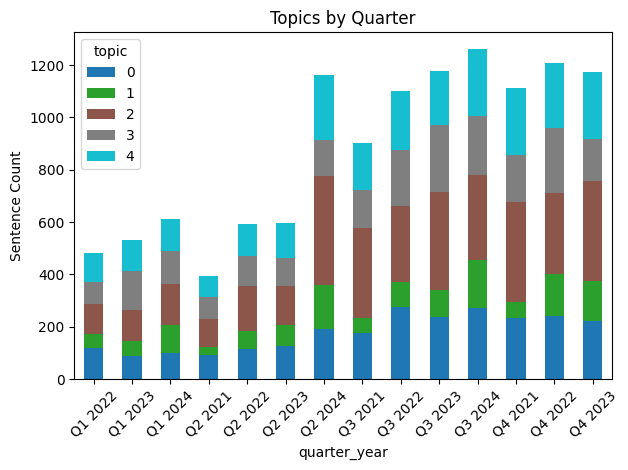

<Figure size 1200x600 with 0 Axes>

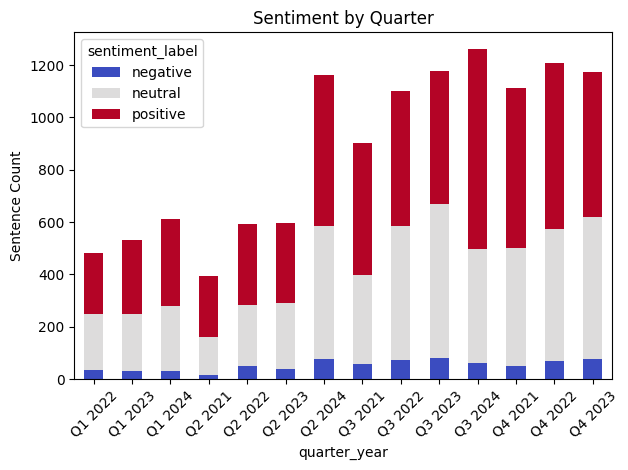

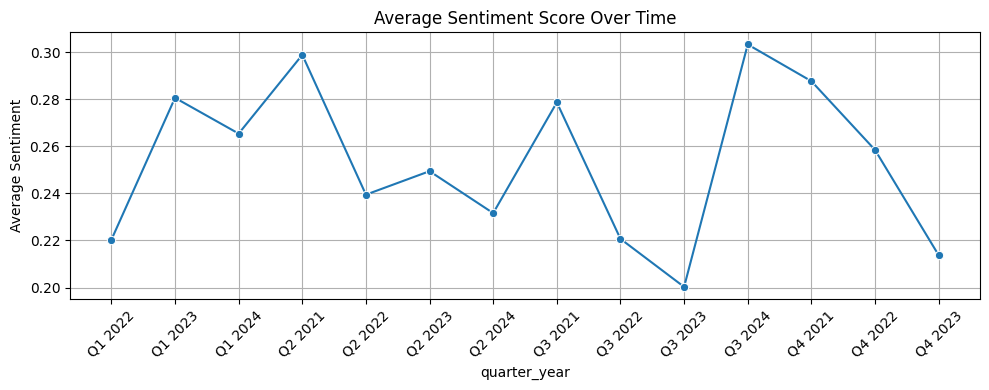

In [7]:

# Bank Earnings Sentiment & Topic Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('vader_lexicon')

# Load sentence-level data
df = pd.read_csv("transcript_sentences.csv")

# --- Sentiment Analysis ---
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['sentence'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')

# --- Topic Modeling (LDA) ---
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['sentence'].astype(str))
lda = LatentDirichletAllocation(n_components=5, random_state=0)
topics = lda.fit_transform(X)
df['topic'] = topics.argmax(axis=1)

# --- 1. Topics by Quarter ---
df['quarter_year'] = df['quarter'].astype(str) + " " + df['year'].astype(str)
topic_dist = df.groupby(['quarter_year', 'topic']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
topic_dist.plot(kind='bar', stacked=True, colormap='tab10')
plt.title("Topics by Quarter")
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Sentiment by Quarter ---
sentiment_dist = df.groupby(['quarter_year', 'sentiment_label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sentiment_dist.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title("Sentiment by Quarter")
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Sentiment Score Trend ---
df_grouped = df.groupby(['quarter_year'])['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_grouped, x='quarter_year', y='sentiment_score', marker='o')
plt.title("Average Sentiment Score Over Time")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


🧱 Topic distribution among negative sentiment sentences:
0    194
1     97
2    172
3    126
4    156
Name: topic, dtype: int64


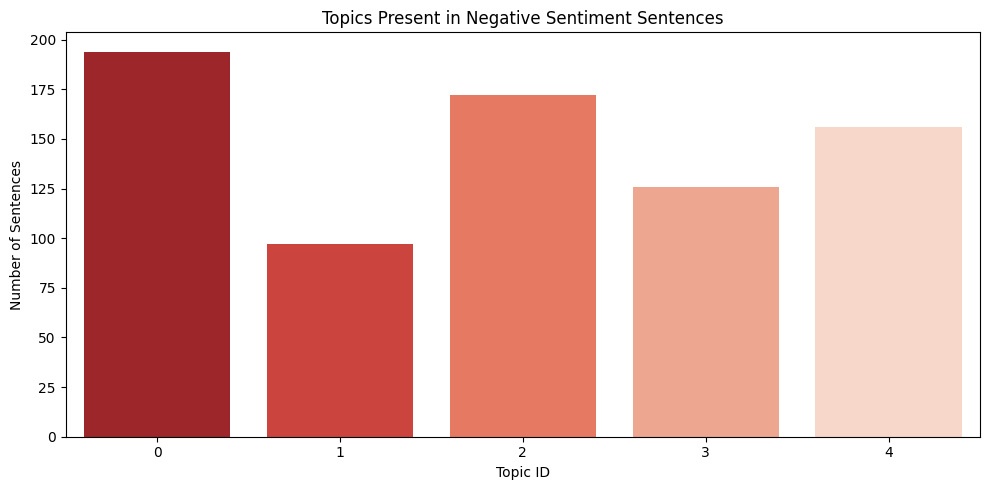


📊 Regulatory themes most mentioned in negative sentiment sentences:
Stress Testing & Scenario Planning     13
Regulators                              8
Capital Adequacy & Buffers              6
Credit Risk & Loan Quality              4
Internal Metrics                        2
Liquidity                               1
Supervisory & Regulatory References     1
Frameworks                              0
dtype: int64


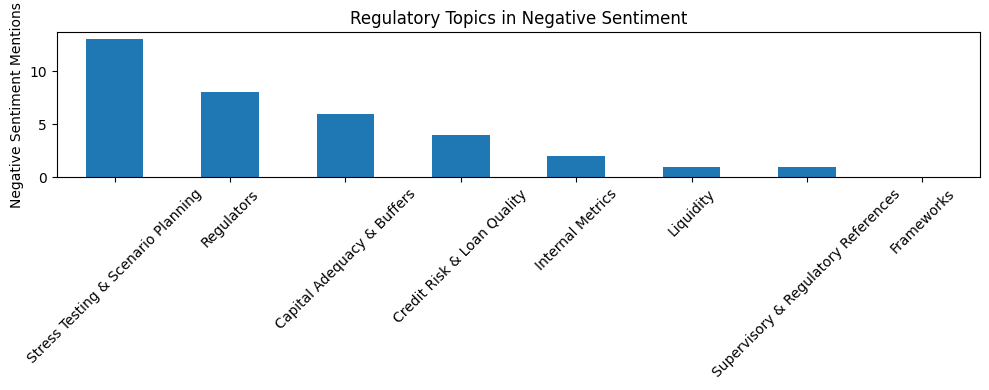

In [9]:
# Filter to negative sentiment only
neg_df = df[df['sentiment_label'] == 'negative'].copy()

# Check distribution of topics within negative sentiment
topic_counts = neg_df['topic'].value_counts().sort_index()
print("🧱 Topic distribution among negative sentiment sentences:")
print(topic_counts)

# Plot it
plt.figure(figsize=(10,5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='Reds_r')
plt.title("Topics Present in Negative Sentiment Sentences")
plt.xlabel("Topic ID")
plt.ylabel("Number of Sentences")
plt.tight_layout()
plt.show()

# Regulation topic columns
reg_cols = [col for col in df.columns if col.startswith("Mentions ")]

# For each regulation topic, count how many negative sentiment sentences mention it
reg_neg_counts = {}
for col in reg_cols:
    count = neg_df[col].eq("Yes").sum()
    reg_neg_counts[col.replace("Mentions ", "")] = count

# Display regulation mentions in negative sentiment
reg_neg_series = pd.Series(reg_neg_counts).sort_values(ascending=False)

print("\n📊 Regulatory themes most mentioned in negative sentiment sentences:")
print(reg_neg_series)

# Optional plot
reg_neg_series.plot(kind='bar', figsize=(10,4), title="Regulatory Topics in Negative Sentiment")
plt.ylabel("Negative Sentiment Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Show top 10 words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: quarter, year, billion, revenues, driven, markets, income, net, higher, expenses
Topic 1: credit, term, line, medium, balance, cost, billion, sheet, open, losses
Topic 2: ve, think, going, transformation, look, got, year, ll, time, investments
Topic 3: growth, client, clients, new, services, strong, continue, cards, seeing, deposits
Topic 4: just, question, think, like, mark, come, jane, nii, bit, yeah
